
#Project_DeepLearning_TransferLearningModel - ResNet50

## Import Libraries

In [0]:
#Importing all the important import 

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
import pandas as pd
import zipfile
import re
import os
from keras.activations import softmax, relu
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.models import Sequential, Model
import pathlib
#from keras.applications.resnet import ResNet50, ResNet152, preprocess_input
from keras_applications.resnet import ResNet50
from keras_applications.resnet import ResNet152
#import Input
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
import numpy as np
import cv2
print(tf.__version__)

1.14.0


Using TensorFlow backend.


##Mount the Drive to access the image data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Import Dataset

#### Extract the training and testing zip files

In [0]:
# Extracting train.zip into the drive
train_zf = zipfile.ZipFile("/content/drive/My Drive/aptos2019-blindness-detection/train_images.zip")
train_zf.extractall(path='/content/drive/My Drive/aptos2019-blindness-detection/train')

# Extracting test.zip into the drive
test_zf = zipfile.ZipFile("/content/drive/My Drive/aptos2019-blindness-detection/test_images.zip")
test_zf.extractall(path='/content/drive/My Drive/aptos2019-blindness-detection/test')

#### Check if the created folders-train and test contain correct number of images or not

In [0]:
import os, os.path

DIR_test = '/content/drive/My Drive/aptos2019-blindness-detection/test'
DIR_train = '/content/drive/My Drive/aptos2019-blindness-detection/train'

print(len([name for name in os.listdir(DIR_test) if os.path.isfile(os.path.join(DIR_test, name))]))
print(len([name for name in os.listdir(DIR_train) if os.path.isfile(os.path.join(DIR_train, name))]))

1928
3662


####Create Dataframes from the csv files. Convert the id_code in the files to match the image names by apending .png

In [0]:
def append_ext(fn):
    return fn+".png"
  
traindf=pd.read_csv('/content/drive/My Drive/aptos2019-blindness-detection/train.csv',dtype=str)
testdf=pd.read_csv("/content/drive/My Drive/aptos2019-blindness-detection/test.csv",dtype=str)

traindf["id_code"]=traindf["id_code"].apply(append_ext)
testdf["id_code"]=testdf["id_code"].apply(append_ext)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

#### Create training and validation data generators by splitting the training data.(75% training +25% validation)

In [0]:
train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/train/",
x_col="id_code",
y_col="diagnosis",
subset="training",
color_mode="rgb",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/train/",
x_col="id_code",
y_col="diagnosis",
subset="validation",
color_mode="rgb",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 14 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2736 validated image filenames belonging to 5 classes.
Found 912 validated image filenames belonging to 5 classes.


#### Create the test datagenerator from the test data. Further which can be used for predictions

In [0]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/test/",
x_col="id_code",
y_col=None,
batch_size=32,
color_mode="rgb",
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

Found 1928 validated image filenames.


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Model - ResNet50

In [0]:
#Building ResNet50 basic model 

input_tensor=Input(shape=(32, 32,3))   #Input size for the model
resnet_model = ResNet50(weights='imagenet', include_top=False, 
                        input_tensor= input_tensor)    
x=GlobalAveragePooling2D()(resnet_model.output)
x=Dropout(0.3)(x) #Adding Dropout  
x=Dense(1024, activation=relu)(x)
x=Dropout(0.2)(x)
x=Dense(512, activation=relu)(x)
x=Dropout(0.2)(x)
output_layer=Dense(5,activation='softmax', name="Output_Layer")(x)
fine_tuning_resnet_model =Model(input_tensor, output_layer)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


###Model Compilation 

In [0]:
from keras.optimizers import Adam, rmsprop, RMSprop
lr = 1e-3
optimizer=rmsprop(lr=lr,decay=0.2) #Using rmsprop optimizer 
fine_tuning_resnet_model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])

373

In [0]:
fine_tuning_resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

###Model Fitting

In [0]:
fine_tuning_resnet_model_history=fine_tuning_resnet_model.fit_generator(generator=train_generator,
                           steps_per_epoch=len(train_generator),
                           validation_data=valid_generator,
                           validation_steps=len(valid_generator),
                           epochs=5,
                           verbose=2)

Epoch 1/5
 - 426s - loss: 1.0814 - acc: 0.6661 - val_loss: 0.9204 - val_acc: 0.7018
Epoch 2/5
 - 376s - loss: 0.8512 - acc: 0.7188 - val_loss: 0.8247 - val_acc: 0.7215
Epoch 3/5
 - 376s - loss: 0.8655 - acc: 0.7126 - val_loss: 0.8629 - val_acc: 0.6963
Epoch 4/5
 - 385s - loss: 0.8554 - acc: 0.7257 - val_loss: 0.8227 - val_acc: 0.7007
Epoch 5/5
 - 381s - loss: 0.7965 - acc: 0.7216 - val_loss: 0.7837 - val_acc: 0.7346


100

In [0]:
fine_tuning_resnet_model_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

##Accuracy Graph for Basic ResNet50

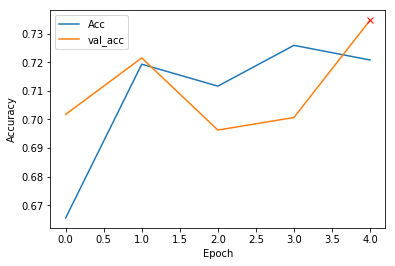

In [0]:
accu=fine_tuning_resnet_model_history.history['acc']
val_acc=fine_tuning_resnet_model_history.history['val_acc']

plt.plot(accu,label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc','val_acc'])
plt.plot( np.argmax(fine_tuning_resnet_model_history.history["val_acc"]), np.max(fine_tuning_resnet_model_history.history["val_acc"]), marker="x", color="r", label="best model")
plt.show()

### Loss Graph for Basic ResNet50


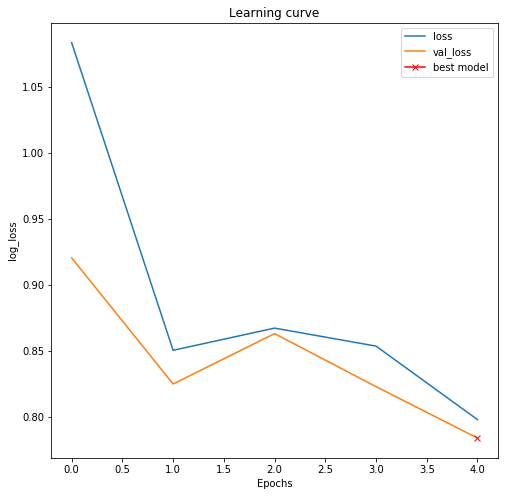

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(fine_tuning_resnet_model_history.history["loss"], label="loss")
plt.plot(fine_tuning_resnet_model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(fine_tuning_resnet_model_history.history["val_loss"]), np.min(fine_tuning_resnet_model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

###Predicting classes for test data using Basic ResNet50


In [0]:
array_steps = 10
preds_array=[]

for i in tqdm(range(array_steps)):
    test_generator.reset()
    preds = fine_tuning_resnet_model.predict_generator(generator=test_generator,steps =len(test_generator))
    preds_array.append(preds)

100%|██████████| 10/10 [19:54<00:00, 92.15s/it]


In [0]:
#print(preds_tta)

print("Preds tta: ",preds_tta)

Preds tta:  [array([[0.29779187, 0.09258966, 0.5506532 , 0.01192605, 0.04703918],
       [0.15601186, 0.29195198, 0.33127266, 0.07583803, 0.14492543],
       [0.19815834, 0.19976081, 0.32922086, 0.10906579, 0.16379422],
       ...,
       [0.19574547, 0.19948515, 0.26609147, 0.15831137, 0.18036653],
       [0.19012754, 0.20157112, 0.24346936, 0.1763003 , 0.18853168],
       [0.9618224 , 0.01122965, 0.0176311 , 0.00154985, 0.00776701]],
      dtype=float32), array([[0.29779187, 0.09258966, 0.5506532 , 0.01192605, 0.04703918],
       [0.15601186, 0.29195198, 0.33127266, 0.07583803, 0.14492543],
       [0.19815834, 0.19976081, 0.32922086, 0.10906579, 0.16379422],
       ...,
       [0.19574547, 0.19948515, 0.26609147, 0.15831137, 0.18036653],
       [0.19012754, 0.20157112, 0.24346936, 0.1763003 , 0.18853168],
       [0.9618224 , 0.01122965, 0.0176311 , 0.00154985, 0.00776701]],
      dtype=float32), array([[0.29779187, 0.09258966, 0.5506532 , 0.01192605, 0.04703918],
       [0.15601186, 

In [0]:
final_pred = np.mean(preds_tta, axis=0)
class_indices_predicted = np.argmax(final_pred, axis=1)
len(class_indices_predicted)

[[0.2977919  0.09258967 0.5506533  0.01192605 0.04703918]
 [0.15601185 0.29195195 0.33127263 0.07583803 0.14492545]
 [0.19815835 0.19976081 0.32922083 0.10906579 0.16379423]
 ...
 [0.19574547 0.19948517 0.26609144 0.15831137 0.18036653]
 [0.19012752 0.20157114 0.24346933 0.1763003  0.18853167]
 [0.9618224  0.01122965 0.0176311  0.00154985 0.00776701]]


1928

In [0]:
print(final_pred)
print(class_indices_predicted)

[[0.2977919  0.09258967 0.5506533  0.01192605 0.04703918]
 [0.15601185 0.29195195 0.33127263 0.07583803 0.14492545]
 [0.19815835 0.19976081 0.32922083 0.10906579 0.16379423]
 ...
 [0.19574547 0.19948517 0.26609144 0.15831137 0.18036653]
 [0.19012752 0.20157114 0.24346933 0.1763003  0.18853167]
 [0.9618224  0.01122965 0.0176311  0.00154985 0.00776701]]
[2 2 2 ... 2 2 0]


In [0]:
results=pd.DataFrame({"id_code":test_generator.filenames, "diagnosis":class_indices_predicted})  
results.id_code=results.id_code.apply(lambda x: x[:-4]) 
results.to_csv("submission.csv", index=False)

## Model ResNet50 - Variation 1


In [0]:
from keras.activations import softmax, relu
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.models import Sequential, Model

input_tensor=Input(shape=(32, 32,3))  
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor= input_tensor)    
x=GlobalAveragePooling2D()(resnet_model.output)
x=Dropout(0.3)(x)
x=Dense(1024, activation=relu)(x)
x=Dropout(0.2)(x)
x=Dense(512, activation=relu)(x)
x=Dropout(0.2)(x)
output_layer=Dense(5,activation='softmax', name="Output_Layer")(x)
fine_tuning_resnet_model =Model(input_tensor, output_layer)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
from keras.optimizers import Adam, rmsprop, RMSprop
lr = 1e-3
optimizer=rmsprop(lr=lr,decay=0.2)
fine_tuning_resnet_model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])

12163

### Adding Early stopping 

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 0, patience = 20)
mc = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 0)

In [0]:
fine_tuning_resnet_model_history=fine_tuning_resnet_model.fit_generator(generator=train_generator,
                           steps_per_epoch=len(train_generator),
                           validation_data=valid_generator,
                           validation_steps=len(valid_generator),
                           epochs=50,
                           callbacks = [es, mc], 
                           use_multiprocessing = True,                    
                           verbose=2)                

Epoch 1/50
 - 447s - loss: 1.1193 - acc: 0.6621 - val_loss: 0.9076 - val_acc: 0.6700
Epoch 2/50
 - 373s - loss: 0.8135 - acc: 0.7246 - val_loss: 0.8053 - val_acc: 0.7039
Epoch 3/50
 - 390s - loss: 0.8185 - acc: 0.7151 - val_loss: 0.7797 - val_acc: 0.7127
Epoch 4/50
 - 381s - loss: 0.6959 - acc: 0.7409 - val_loss: 0.7510 - val_acc: 0.7336
Epoch 5/50
 - 368s - loss: 0.7175 - acc: 0.7297 - val_loss: 0.7798 - val_acc: 0.7138
Epoch 6/50
 - 372s - loss: 0.6871 - acc: 0.7442 - val_loss: 0.7449 - val_acc: 0.7270
Epoch 7/50
 - 368s - loss: 0.7440 - acc: 0.7525 - val_loss: 0.7619 - val_acc: 0.7237
Epoch 8/50
 - 366s - loss: 0.6325 - acc: 0.7533 - val_loss: 0.7499 - val_acc: 0.7292
Epoch 9/50
 - 368s - loss: 0.6385 - acc: 0.7431 - val_loss: 0.7485 - val_acc: 0.7346
Epoch 10/50
 - 371s - loss: 0.6184 - acc: 0.7594 - val_loss: 0.7799 - val_acc: 0.7270
Epoch 11/50
 - 366s - loss: 0.5896 - acc: 0.7707 - val_loss: 0.7788 - val_acc: 0.7303
Epoch 12/50
 - 369s - loss: 0.5915 - acc: 0.7649 - val_loss: 0.

658

### Accuracy Graph

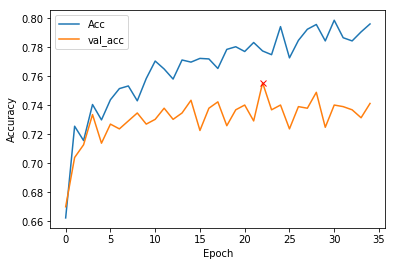

In [0]:
accu=fine_tuning_resnet_model_history.history['acc']
val_acc=fine_tuning_resnet_model_history.history['val_acc']
plt.plot(accu,label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc','val_acc'])
plt.plot( np.argmax(fine_tuning_resnet_model_history.history["val_acc"]), np.max(fine_tuning_resnet_model_history.history["val_acc"]), marker="x", color="r", label="best model")
plt.show()

## Model ResNet50 - Variation 2


In [0]:
train_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/train/",
x_col="id_code",
y_col="diagnosis",
subset="training",
color_mode="rgb",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_datagen=ImageDataGenerator(rescale=1./255)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/train/",
x_col="id_code",
y_col="diagnosis",
subset="validation",
color_mode="rgb",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/test/",
x_col="id_code",
y_col=None,
batch_size=32,
color_mode="rgb",
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

### Adding BatchNormalization 

In [0]:
from keras.activations import softmax, relu
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization
from keras.models import Sequential, Model

input_tensor=Input(shape=(32, 32,3))
  
resnet_model1 = ResNet50(weights='imagenet', include_top=False, input_tensor= input_tensor)    
x=GlobalAveragePooling2D()(resnet_model1.output)
x=Dropout(0.3)(x)
x=Dense(1024, activation=relu)(x)
x=Dropout(0.2)(x)
x=Dense(512, activation=relu)(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
output_layer=Dense(5,activation='softmax', name="Output_Layer")(x)
fine_tuning_resnet_model1 =Model(input_tensor, output_layer)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
from keras.optimizers import Adam, rmsprop, RMSprop
import gc

lr = 1e-3
optimizer=rmsprop(lr=lr,decay=0.2)
fine_tuning_resnet_model1.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])

W0722 16:49:57.688206 140108285081472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



1933

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 0, patience = 20)
mc = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 0)

In [0]:
fine_tuning_resnet_model1_history=fine_tuning_resnet_model1.fit_generator(generator=train_generator,
                           steps_per_epoch=len(train_generator),
                           validation_data=valid_generator,
                           validation_steps=len(valid_generator),
                           epochs=10,
                           callbacks = [es, mc], 
                           use_multiprocessing = True,                    
                           verbose=2)      

Epoch 1/10
 - 2153s - loss: 1.0841 - acc: 0.6432 - val_loss: 0.8819 - val_acc: 0.7138
Epoch 2/10
 - 350s - loss: 0.9201 - acc: 0.6850 - val_loss: 0.8412 - val_acc: 0.7094
Epoch 3/10
 - 368s - loss: 0.8060 - acc: 0.7166 - val_loss: 0.8035 - val_acc: 0.7292
Epoch 4/10
 - 370s - loss: 0.8099 - acc: 0.7227 - val_loss: 0.7795 - val_acc: 0.7259
Epoch 5/10
 - 369s - loss: 0.8028 - acc: 0.7268 - val_loss: 0.7628 - val_acc: 0.7281
Epoch 6/10
 - 367s - loss: 0.7803 - acc: 0.7307 - val_loss: 0.7803 - val_acc: 0.7292
Epoch 7/10
 - 370s - loss: 0.7543 - acc: 0.7362 - val_loss: 0.7589 - val_acc: 0.7303
Epoch 8/10
 - 369s - loss: 0.7485 - acc: 0.7322 - val_loss: 0.7575 - val_acc: 0.7325
Epoch 9/10
 - 368s - loss: 0.7167 - acc: 0.7507 - val_loss: 0.7570 - val_acc: 0.7346
Epoch 10/10
 - 369s - loss: 0.7398 - acc: 0.7431 - val_loss: 0.7462 - val_acc: 0.7368


91

### Graph for Accuracy

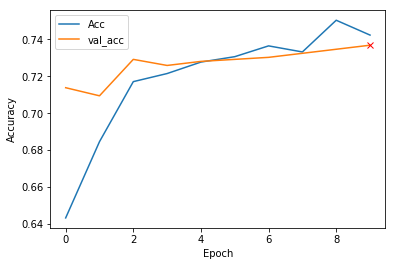

In [0]:
accu=fine_tuning_resnet_model1_history.history['acc']
val_acc=fine_tuning_resnet_model1_history.history['val_acc']

plt.plot(accu,label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc','val_acc'])
plt.plot( np.argmax(fine_tuning_resnet_model1_history.history["val_acc"]), np.max(fine_tuning_resnet_model1_history.history["val_acc"]), marker="x", color="r", label="best model")
plt.show()

### Graph for Loss

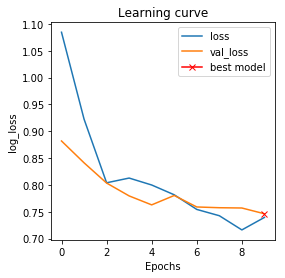

In [0]:
plt.figure(figsize=(4,4))
plt.title("Learning curve")
plt.plot(fine_tuning_resnet_model1_history.history["loss"], label="loss")
plt.plot(fine_tuning_resnet_model1_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(fine_tuning_resnet_model1_history.history["val_loss"]), np.min(fine_tuning_resnet_model1_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();